In [1]:
import torch
from torchvision import models, transforms
import torch.optim as optim
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
model=models.vgg19(pretrained=True).features
for par in model.parameters():
    par.requires_grad_(False)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
def model_activations(input, model):
    layers = {
        '0':'convo1_1',
        '5':'convo2_1',
        '10':'convo3_1',
        '19':'convo4_1',
        '21':'convo4_2',
        '28':'convo5_1',        
    }
    features = {}
    x = input
    x = x.unsqueeze(0)
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [5]:
transform = transforms.Compose([transforms.Resize(400),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
content = Image.open('mona.jpg').convert('RGB')
style = Image.open('van_goo.jpg').convert('RGB')
style = transform(style).to(device)
content = transform(content).to(device)

In [7]:
def imcnvt(image):
    x = image.to('cpu').clone().detach().numpy().squeeze()
    x = x.transpose(1, 2, 0)
    x = x*np.array((0.5, 0.5, 0.5))+np.array((0.5, 0.5, 0.5))
    return x

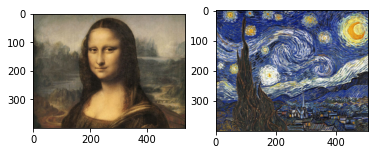

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(imcnvt(content), label="Content")
ax2.imshow(imcnvt(style), label="Style")
plt.show()

In [10]:
def gram_matrix(imgfeature):
    _, d, h, w = imgfeature.size()
    imgfeature = imgfeature.view(d, h * w)
    gram = torch.mm(imgfeature, imgfeature.t())
    return gram

In [11]:
target = content.clone().requires_grad_(True).to(device)

In [12]:
content_features = model_activations(content, model)
style_features = model_activations(style, model)

In [13]:
style_wt_meas = {"conv1_1" : 0.4,
                 "conv2_1" : 0.3,
                 "conv3_1" : 0.2,
                 "conv4_1" : 0.2,
                 "conv5_1" : 0.2}

In [15]:
style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

In [16]:
content_wt = 1000
style_wt = 1e8

In [17]:
print_after = 100
epochs = 4000
optimizer = torch.optim.Adam([target], lr=0.2)

In [20]:
for i in range(1, epochs+1):
    target_features = model_activations(target, model)
    content_loss = torch.mean((target_features['conv4_2']-content_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_wt_meas:
        style_gram = style_grams[layer]
        target_gram = target_features[layer]
        _,d,w,h = target_gram.shape
        target_gram = gram_matrix(target_gram)
        
        style_loss += (style_wt_meas[layer]*torch.mean((target_gram-style_gram)**2))/d*w*h
    
    total_loss = content_wt*content_loss + style_wt*style_loss
    
    if(i%10 == 0):
        print("epoch ", i, " ", total_loss.item())
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if(i%print_after == 0):
        plt.imshow(imcnvt(target), label="Epoch "+str(i))
        plt.show()
        plt.imshow(str(i)+'.png', imcnvt(target), format='png')

KeyError: 'conv4_2'